In [1]:
#!pip install gensim

# Trabajando con Gensim - LDA

# MINERÍA DE TEXTOS

## Alumna: Jessica Sarahi Méndez Rincón


# Tarea 11
 
Utilizar los topicos generados con LDA como características para clasificar correos electrónicos en SPAM y NO SPAM. Evaluar los modelos de clasificación con distintos números de tópicos para los algoritmos de clasificación previamente utilizados.


In [2]:
# Importacion de librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score, confusion_matrix
import os


## Preparación del dataset

In [3]:
# Importacion del archivo que se nos proporciono agregandole cabeceras que no contiene
names = ['tweet']
mi_correo = pd.read_csv('spam.csv', sep=',', encoding = "latin-1") 
mi_correo
del mi_correo['Unnamed: 2']
del mi_correo['Unnamed: 3']
del mi_correo['Unnamed: 4']

mi_correo.rename(columns=dict(v1="Class", v2="Message"), inplace=True)
mi_correo.head(5)

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#Separar el conjunto de entrenamiento y de test
limit = int(0.9*len(mi_correo))
train = mi_correo.loc[:limit]
test = mi_correo.loc[limit:]

## Modelo LDA

In [6]:
# Usamos el constructor gensim.models.ldamodel.LdaModel para estimar
# los parámetros del modelo LDA en el corpus, y guardar en la variable `ldamodel`
#ldamodel = gensim.models.ldamodel.LdaModel (corpus, num_topics=10, id2word=id_map, passes=25, random_state=34)

Nos quedamos con una sola característica en nuestro conjunto de datos, el contenido del mensaje en sí. Debemos encontrar una manera de extraer características de estos mensajes para poder entrenar un modelo de aprendizaje automático que pueda identificar un mensaje de spam. 
Un modelo de tema es un modelo de aprendizaje automático no supervisado que se puede entrenar en un corpus (una colección de documentos) para identificar los temas dentro de esos documentos. En este contexto, un tema generalmente se define como una distribución de probabilidad de todos los términos del vocabulario del corpus que aparecen para ese tema dado.

Un modelo de tema popular es la asignación de Dirichlet latente (LDA). Al entrenar un modelo LDA en nuestros datos de entrenamiento, podemos usar este modelo para representar mensajes como vectores de ponderación de tema, donde el valor de cada elemento del vector de ponderación de tema corresponde al peso en el que ese mensaje dado exhibe el tema asociado. Sin embargo, una advertencia con el uso de LDA es que se debe establecer de forma preventiva el número de temas que se cree que se exhiben en un corpus antes de entrenar un modelo LDA en él. Usando el paquete de modelado de temas **Gensim**, entrenaremos un modelo LDA en el conjunto de entrenamiento y usaremos este modelo LDA para transformar los datos de entrenamiento y el conjunto de prueba en vectores con peso. Usaremos el valor predeterminado de Gensim de 100 temas para esta tarea.

Dado que a veces se puede derivar más significado de las palabras cuando se toman juntas en lugar de individualmente (es decir, 'hasta luego' en lugar de los términos individuales 'ver', 'usted' y 'más tarde'), tomaremos en consideración no solo términos individuales, sino colecciones de términos (también conocidos como n-gramas). Tomaremos en consideración n-gramos con n igual a 1, 2 y 3 (también conocidos como unigramas, bigramas y trigramas, respectivamente). Todas las palabras vacías en inglés (es decir, y, etc.) se ignorarán y no ofrecerán información útil con respecto al tema de estos mensajes. Para simplificar, cuando se utiliza el modelo LDA para transformar mensajes en vectores de tema, cualquier tema que tenga una probabilidad menor de 0.01 de ser exhibido por ese mensaje automáticamente tendrá su peso de tema establecido en cero para ese mensaje.

In [7]:
vectorizer = CountVectorizer(stop_words="english", 
                             ngram_range=(1, 3))
term_document_matrix = vectorizer.fit_transform(train.Message)
corpus = Sparse2Corpus(term_document_matrix, documents_columns=False)
id2word = {value: key for key, value in vectorizer.vocabulary_.items()}
model = LdaModel(corpus=corpus, 
                 id2word=id2word, 
                 random_state=0)
def transform_messages_to_topic_vectors(data, vectorizer, model):
    num_topics = model.num_topics
    message_topics = pd.DataFrame(index=map(str, range(num_topics)))    
    for index, message in data.Message.iteritems():
        message_transformed = (vectorizer.transform([message]))
        message_corpus = (Sparse2Corpus(message_transformed, documents_columns=False))
        topics_framework = dict.fromkeys(map(str, range(0, num_topics)))
        topics_specific = dict(list(model[message_corpus])[0])
        for key in topics_specific:
            topics_framework[str(key)] = topics_specific[key]
        message_topics[index] = pd.Series(topics_framework)
    message_topics = message_topics.T.fillna(0)
    data = data.join(message_topics)
    data.drop("Message", axis=1, inplace=True)
    data = pd.get_dummies(data, drop_first=True)
    data.rename(columns=dict(Class_spam="Spam"), inplace=True)
    return data

## Ejecutar modelo LDA

In [8]:
# Retorna una lista de los 10 topicos y las 10 palabras más significativas en cada topico.

train = transform_messages_to_topic_vectors(train, vectorizer, model)
test = transform_messages_to_topic_vectors(test, vectorizer, model)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Spam
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.08809,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077279,0.0,0
2,0.0,0.984495,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0


## Distribución de tópicos


Al ver nuestros datos de entrenamiento transformados, podemos ver que los vectores de peso del tema que representan los mensajes son escasos. Esto se debe a que los mensajes parecen representar la mayoría de los temas del modelo LDA con una probabilidad baja. Veamos la distribución de cuántos mensajes muestran un número determinado de temas.

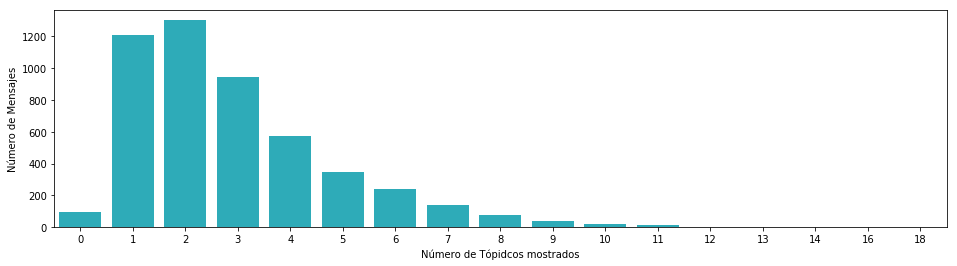

In [9]:
topics = list(train.columns)
topics.remove("Spam")
ax = sns.countplot(train[topics].astype(bool).sum(axis=1), color="C9")
ax.set_xlabel("Número de Tópidcos mostrados")
ax.set_ylabel("Número de Mensajes")
fig = plt.gcf()
fig.set_size_inches(16, 4)

Como podemos ver, aunque tenemos mensajes que solo exhiben un tema, o en algunos casos cero (debido a que todas las ocurrencias de temas son de baja probabilidad), podemos ver que muchos mensajes tratan sobre múltiples temas. Veamos a la inversa cuántos mensajes exhiben cada tema particular del modelo LDA.

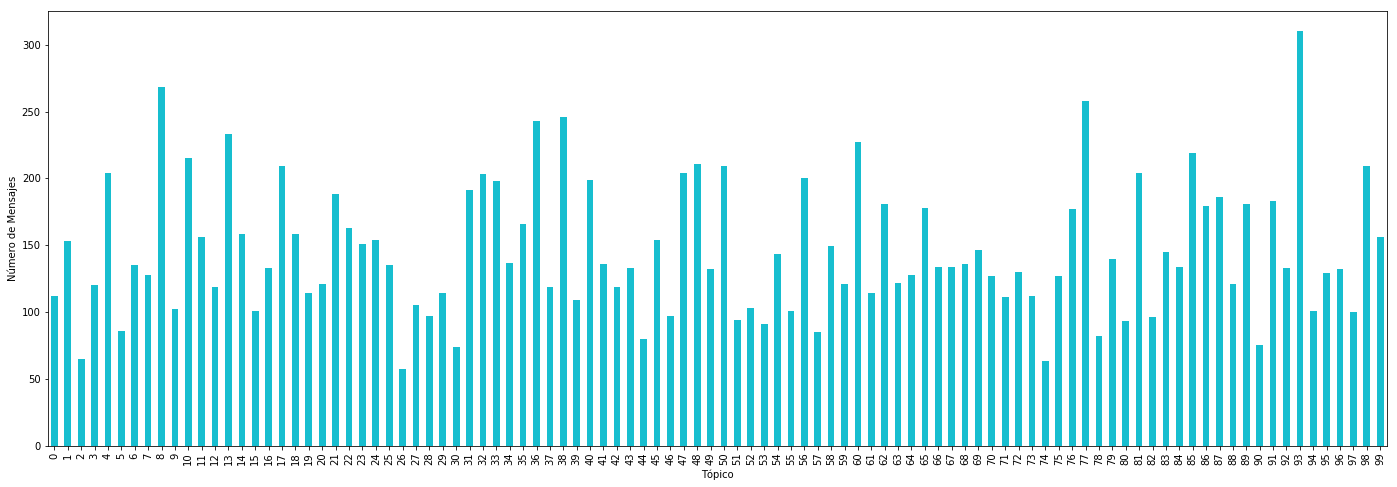

In [10]:
ax = train[topics].astype(bool).sum(axis=0).plot.bar(color="C9")
ax.set_xlabel("Tópico")
ax.set_ylabel("Número de Mensajes")
fig = plt.gcf()
fig.set_size_inches(24, 8)

In [11]:
print("Los n-gramas más sobresalientes en los tópicos más sobresalientes:\n- {}".format('\n- '.join([id2word[term[0]] for term in model.get_topic_terms(50)])))

Los n-gramas más sobresalientes en los tópicos más sobresalientes:
- know
- let
- let know
- mayb
- want
- missed
- xmas
- time
- driving
- 800


Al ver los n-gramas más frecuentes en el tema 50, podemos ver que parece haber muchas disculpas en el conjunto de entrenamiento. Aunque, por supuesto, hay mensajes de spam y de radioaficionados presentes en el conjunto de datos, valdría la pena ver la distribución entre estas dos clases en el conjunto de entrenamiento, para posiblemente tener esto en cuenta al entrenar un modelo de aprendizaje automático de detección de spam.

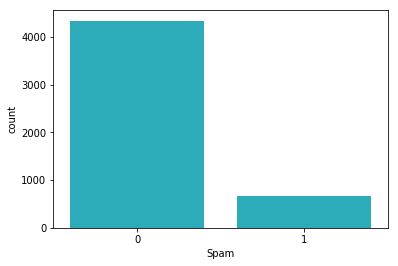

In [12]:
X_train = train.drop("Spam", axis=1)
Y_train = train.Spam
X_test = test.drop("Spam", axis=1)
Y_test = test.Spam
sns.countplot(Y_train, color="C9")

Como podemos ver, hay mucho más jamón que mensajes de spam en nuestro conjunto de entrenamiento. Este desequilibrio de clases es un problema común en el aprendizaje automático. Debido a este desequilibrio de clases, solo confirmemos que hay mensajes de spam en el conjunto de prueba y que no todos los mensajes de spam se colocaron accidentalmente en el conjunto de entrenamiento.

In [13]:
print("Número de mensajes de spam en el conjunto de prueba: {}"\
      .format(test["Spam"].value_counts()[1]))

Número de mensajes de spam en el conjunto de prueba: 72
